In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.ndimage import zoom
import pandas as pd
from pipeline_setup import *
import time
from scipy.optimize import minimize

In [2]:
# Set file locations
advanced_settings_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTanjc08kc5vIN-icUMzMEGA9bJuDesLX8V_u2Ab6zSC4MOhLZ8Jrr18DL9o4ofKIrSq6FsJXhPWu3F/pub?gid=0&single=true&output=csv"

# Read in emissions from other sectors
sector_emissions_dict = set_sector_emissions_dict()
# Read in the advanced settings from the google sheet
params = read_advanced_settings(advanced_settings_url)
# Set the datablock
datablock_init = datablock_setup()

# Set the scenario parameters
params_baseline = set_baseline_scenario(params)

# Also add the baseline parameters to the datablock
datablock_init.update(params_baseline)

In [3]:
# Name the output parameters of the current calculator function 
# (ideally these would be set and returned by the calculator)
z1_name = "SSR"
z2_name = "emissions"

# Name the params we are going to vary
name1 = "horticulture"
name2 = "foresting_pasture"

In [4]:
# Do a test calculation
z1_val_baseline, z2_val_baseline = SSR_emissions(datablock_init, params_baseline, timing=True)
#print(f"SSR = {SSR_result:.8f}; GHG = {emissions_result:.8f}")
print(f"{z1_name} = {z1_val_baseline:.8f}; {z2_name} = {z2_val_baseline:.8f}")
# This is my checksum for debugging: 
# SSR = 0.67366432; GHG = 94.22954995

Node 1 (Node 1) executed in 0.1288 seconds.
Node 2 (Node 2) executed in 0.3349 seconds.
Node 3 (Node 3) executed in 0.2001 seconds.
Node 4 (Node 4) executed in 0.1691 seconds.
Node 5 (Node 5) executed in 0.0727 seconds.
Node 6 (Node 6) executed in 0.0858 seconds.
Node 7 (Node 7) executed in 0.1786 seconds.
Node 8 (Node 8) executed in 0.0731 seconds.
Node 9 (Node 9) executed in 0.0695 seconds.
Node 10 (Node 10) executed in 0.0212 seconds.
Node 11 (Node 11) executed in 0.0245 seconds.
Node 12 (Node 12) executed in 0.0788 seconds.
Node 13 (Node 13) executed in 0.0826 seconds.
Node 14 (Node 14) executed in 0.0472 seconds.
Node 15 (Node 15) executed in 0.0369 seconds.
Node 16 (Node 16) executed in 0.1301 seconds.
Node 17 (Node 17) executed in 0.1258 seconds.
Node 18 (Node 18) executed in 0.0042 seconds.
Node 19 (Node 19) executed in 0.0028 seconds.
Node 20 (Node 20) executed in 0.0737 seconds.
Node 21 (Node 21) executed in 0.0039 seconds.
Node 22 (Node 22) executed in 0.0030 seconds.
Node 2

In [5]:
# Create an class with anobjective function suitable for giving to the scipy minimizer
# Including a cache to avoid recomputing the same values
class FFCObjectiveWithCache:
    """A class to compute the objective function and constraints for FFC optimization with caching.
    Parameters:
        names_x (list): List of parameter names to be optimized.
        datablock_init (dict): Initial data block containing fixed parameters.
        params_default (dict): Default parameters for the optimization.
        sector_emissions_dict (dict): Dictionary containing emissions data for different sectors.
        verbosity (int): Level of verbosity for output messages.
    """
    def __init__(self, names_x, datablock_init, params_default, verbosity=0):
        self.names_x = names_x
        self.datablock_init = datablock_init
        self.params_default = params_default
        # self.sector_emissions_dict = sector_emissions_dict
        self._cache = {}
        self.verbosity = verbosity

    def _calculate(self, x_tuple, verbosity):
        
        x = list(x_tuple)
        # Only recompute if not already cached
        
        if x_tuple not in self._cache:

            # Update the parameters with the current values
            params = self.params_default.copy()
            for i_name, name_string in enumerate(self.names_x):
                params[name_string] = x[i_name]
            
            # Perform the SSR and emissions calculation
            SSR_val, emissions_val = SSR_emissions(self.datablock_init, params)

            # Store the results in the cache
            self._cache[x_tuple] = {'SSR': SSR_val, 'emissions': emissions_val}

        # Print out what's going on 
        if (verbosity > 1):
            for i_name, name_string in enumerate(self.names_x):
                print(f"{name_string} = {x[i_name]:.10f}; ", end="")
            for i_name, name_string in enumerate(list(self._cache[x_tuple].keys())):
                print(f"{name_string} = {self._cache[x_tuple][name_string]:.10f}; ", end="")
            print()

        return self._cache[x_tuple]

    # Define the objective function for minimization
    def objective(self, x, z_name_requested):
        x_tuple = tuple(x)
        return self._calculate(x_tuple, self.verbosity)[z_name_requested]

    # Define the objective function for SSR constraint
    def constraint_SSR(self, x, SSR_threshold):
        x_tuple = tuple(x)
        return self._calculate(x_tuple, self.verbosity)['SSR'] - SSR_threshold
    

In [6]:
# Do a test calculation using the new objective function
names_x = (name1, name2)
ffc_wrapper = FFCObjectiveWithCache(names_x, datablock_init, params_baseline, verbosity=2)

x = (params_baseline[names_x[0]], params_baseline[names_x[1]])
print(f"{names_x[0]} = {x[0]:.8f}; {names_x[1]} = {x[1]:.8f}")

horticulture = 0.00000000; foresting_pasture = 13.17000000


In [7]:
z1_val = ffc_wrapper.objective(x, z1_name)
z2_val = ffc_wrapper.objective(x, z2_name)
#fun, ffc_results = ffc_objective(x, names_x, "emissions", datablock_init, params_baseline)
#ffc_results
# This is my checksum for debugging: 
# SSR = 0.67366432; GHG = 94.22954995

# Check I can extract them in the old format
#z1_val, z2_val = list(ffc_results.values())[:2]
#z1_val
#z2_val
print(f"{z1_name} = {z1_val:.8f}; {z2_name} = {z2_val:.8f}")

horticulture = 0.0000000000; foresting_pasture = 13.1700000000; SSR = 0.6736643225; emissions = 94.7772917449; 
horticulture = 0.0000000000; foresting_pasture = 13.1700000000; SSR = 0.6736643225; emissions = 94.7772917449; 
SSR = 0.67366432; emissions = 94.77729174


In [8]:
# Make a 2d plot
ns = (4, 5)
x_mins = (0, 15)
x_maxs = (200, 50)

# Now make the arrays
x1_vals = np.linspace(x_mins[0], x_maxs[0], ns[0])
x2_vals = np.linspace(x_mins[1], x_maxs[1], ns[1])
z1_mat = np.empty((ns[0], ns[1]))
z2_mat = np.empty((ns[0], ns[1]))
x1_mat = np.empty((ns[0], ns[1]))
x2_mat = np.empty((ns[0], ns[1]))

# Initialise for the loop
#params = params_baseline.copy()
starttime = time.time()
#args = (names_x, datablock_init, params, sector_emissions_dict)

# Loop over a grid in 2 of the parameters as specified 
for i1, x1_val in enumerate(x1_vals):
    #params[name1] = x1_val

    for i2, x2_val in enumerate(x2_vals):
        #params[name2] = x2_val

        #z1_val, z2_val = SSR_emissions(datablock_init, params, sector_emissions_dict)
        x = (x1_val, x2_val)
        #fun, ffc_results = ffc_objective(x, names_x, datablock_init, params_baseline, sector_emissions_dict)
        #z1_val, z2_val = list(ffc_results.values())[:2]
        # z1_val = ffc_objective(x, names_x, z1_name, datablock_init, params_baseline, sector_emissions_dict)
        # z2_val = ffc_objective(x, names_x, z2_name, datablock_init, params_baseline, sector_emissions_dict)
        z1_val = ffc_wrapper.objective(x, z1_name)
        z2_val = ffc_wrapper.objective(x, z2_name)
        z1_mat[i1, i2] = z1_val
        z2_mat[i1, i2] = z2_val
        x1_mat[i1, i2] = x1_val
        x2_mat[i1, i2] = x2_val

    lasttime = time.time()
    duration = lasttime - starttime
    eta = (duration / (i1+1) * (ns[0]-i1-1))/60
    print(f"Done i1 = {i1:2} of {ns[0]:2}; eta = {eta:.2f} minutes")

totaltime = time.time()
time_per_function_call = (totaltime - starttime) / (ns[0] * ns[1])
print(f"time_per_function_call = {time_per_function_call:.2f} seconds")

horticulture = 0.0000000000; foresting_pasture = 15.0000000000; SSR = 0.6631258000; emissions = 91.5135343266; 
horticulture = 0.0000000000; foresting_pasture = 15.0000000000; SSR = 0.6631258000; emissions = 91.5135343266; 
horticulture = 0.0000000000; foresting_pasture = 23.7500000000; SSR = 0.6127364319; emissions = 75.9822309869; 
horticulture = 0.0000000000; foresting_pasture = 23.7500000000; SSR = 0.6127364319; emissions = 75.9822309869; 
horticulture = 0.0000000000; foresting_pasture = 32.5000000000; SSR = 0.5623472551; emissions = 60.4532072798; 
horticulture = 0.0000000000; foresting_pasture = 32.5000000000; SSR = 0.5623472551; emissions = 60.4532072798; 
horticulture = 0.0000000000; foresting_pasture = 41.2500000000; SSR = 0.5119580237; emissions = 44.9243850527; 
horticulture = 0.0000000000; foresting_pasture = 41.2500000000; SSR = 0.5119580237; emissions = 44.9243850527; 
horticulture = 0.0000000000; foresting_pasture = 50.0000000000; SSR = 0.4615687991; emissions = 29.39557

In [9]:
# Interpolate the outputs
ni = 100 # Factor by which to interpolate
z1_mati = zoom(z1_mat, zoom=ni, order=3)  # cubic interpolation
z2_mati = zoom(z2_mat, zoom=ni, order=3)  # cubic interpolation
x1_mati = zoom(x1_mat, zoom=ni, order=3)  # cubic interpolation
x2_mati = zoom(x2_mat, zoom=ni, order=3)  # cubic interpolation

In [10]:
# cut all values where the SSR went below today's value
SSR_threshold = 0.7202
emissions_fill_value = 94.23
#SSR_masked_resultsi = np.ma.masked_less(SSR_resultsi, SSR_threshold)

In [11]:
# create a mask using the constraint on SSR
indices_mask = np.where(z1_mati < SSR_threshold)
z1_mati_mask = z1_mati.copy()
z2_mati_mask = z2_mati.copy()
z1_mati_mask[indices_mask] = 1
z2_mati_mask[indices_mask] = emissions_fill_value

In [12]:
# Find the minimum emissions where SSR is greater than today
indices_best = np.where(z2_mati_mask == np.min(z2_mati_mask))
x1_best = x1_mati[indices_best]
x2_best = x2_mati[indices_best]
z1_best = z1_mati[indices_best]
z2_best = z2_mati[indices_best]
print(f"{name1} = {x1_best}; {name2} = {x2_best}; {z2_name} = {z2_best}; {z1_name} = {z1_best}")
# horticulture = [171.40442831]; foresting_pasture = [50.]; emissions = [41.85509712]; SSR = [0.72069789]
# or with new values for sequestration:
# horticulture = [171.40442831]; foresting_pasture = [50.]; emissions = [0.93579712]; SSR = [0.72069789]

horticulture = [200.]; foresting_pasture = [27.39692937]; emissions = [69.47939269]; SSR = [0.72054297]


Text(0.5, 0, 'foresting_pasture')

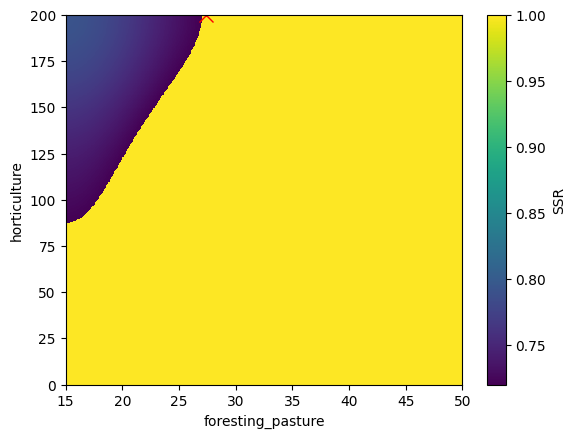

In [13]:
# Plot the resulting SSR w mask
plt.imshow(z1_mati_mask, cmap='viridis', interpolation='nearest', extent=[x_mins[1], x_maxs[1], x_mins[0], x_maxs[0]], origin='lower', aspect='auto')
plt.plot(x2_best, x1_best, marker='x', color='red', markersize=10)
plt.colorbar(label=z1_name)
plt.ylabel(name1)
plt.xlabel(name2)

Text(0.5, 0, 'foresting_pasture')

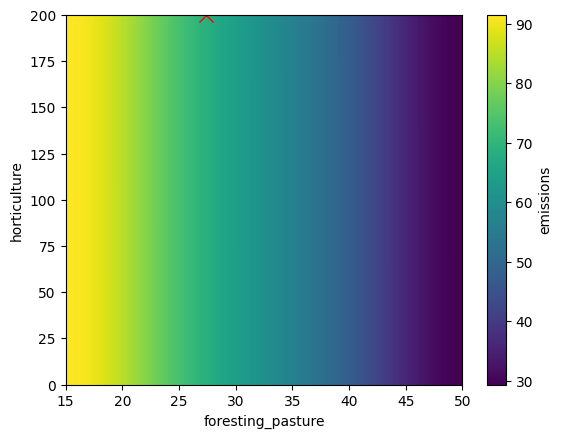

In [14]:
# Plot the resulting emissions
plt.imshow(z2_mati, cmap='viridis', interpolation='nearest', extent=[x_mins[1], x_maxs[1], x_mins[0], x_maxs[0]], origin='lower', aspect='auto')
plt.plot(x2_best, x1_best, marker='x', color='red', markersize=10)
plt.colorbar(label=z2_name)
plt.ylabel(name1)
plt.xlabel(name2)

Text(0.5, 0, 'foresting_pasture')

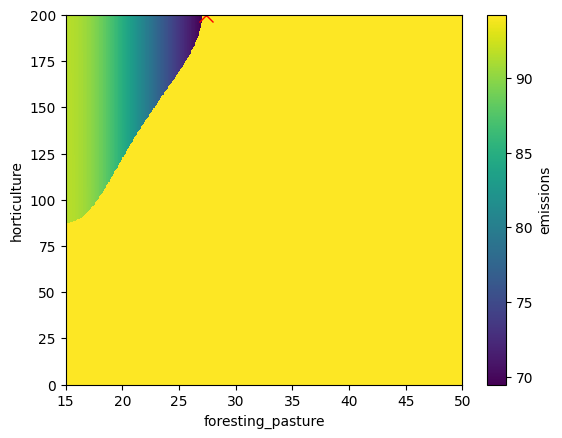

In [15]:
# Plot the resulting emissions, w mask
plt.imshow(z2_mati_mask, cmap='viridis', interpolation='nearest', extent=[x_mins[1], x_maxs[1], x_mins[0], x_maxs[0]], origin='lower', aspect='auto')
plt.plot(x2_best, x1_best, marker='x', color='red', markersize=10)
plt.colorbar(label=z2_name)
plt.ylabel(name1)
plt.xlabel(name2)

In [16]:
# Set the bounds for the optimisation - to be the same as for the grid
x_bounds = bounds=[(x_mins[0], x_maxs[0]), (x_mins[1], x_maxs[1])] # todo make this nd

In [17]:
# Set tolerances, verbosity, and options for the minimizer
ffc_tol = 1e-6
options = {
    'disp': True,      # Show convergence messages
    'maxiter': 100,     # Max number of iterations
    'rhobeg' : 10 # Reasonable step size (mostly they are percentages, so change by 10%)
}


In [18]:
ffc_wrapper = FFCObjectiveWithCache(names_x, datablock_init, params_baseline, verbosity=2)

z_name_requested = "emissions"
x0 = [params_baseline[n] for n in names_x]
ffc_constraints = [{'type': 'ineq', 'fun': lambda x: ffc_wrapper.constraint_SSR(x, SSR_threshold=0.7202)}]

result = minimize(
    lambda x: ffc_wrapper.objective(x, z_name_requested),
    x0,
    method='COBYLA',
    bounds=x_bounds,
    constraints=ffc_constraints,
    tol=ffc_tol,
    options=options
)

horticulture = 0.0000000000; foresting_pasture = 13.1700000000; SSR = 0.6736643225; emissions = 94.7772917449; 
horticulture = 0.0000000000; foresting_pasture = 13.1700000000; SSR = 0.6736643225; emissions = 94.7772917449; 
horticulture = 0.0000000000; foresting_pasture = 13.1700000000; SSR = 0.6736643225; emissions = 94.7772917449; 
horticulture = 10.0000000000; foresting_pasture = 13.1700000000; SSR = 0.6801047407; emissions = 94.7757844570; 
horticulture = 10.0000000000; foresting_pasture = 13.1700000000; SSR = 0.6801047407; emissions = 94.7757844570; 
horticulture = 10.0000000000; foresting_pasture = 23.1700000000; SSR = 0.6225170535; emissions = 77.0101040634; 
horticulture = 10.0000000000; foresting_pasture = 23.1700000000; SSR = 0.6225170535; emissions = 77.0101040634; 
horticulture = 15.6996436837; foresting_pasture = 14.9533059033; SSR = 0.6735058369; emissions = 91.5940959657; 
horticulture = 15.6996436837; foresting_pasture = 14.9533059033; SSR = 0.6735058369; emissions = 91

In [19]:
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 69.3739478430083
       x: [ 2.000e+02  2.746e+01]
    nfev: 40
   maxcv: 6.696212806467372e-09

In [20]:
# The result is an OptimizeResult object
print("Optimization success:", result.success)
print("Message:", result.message)
print("Number of iterations:", result.nfev)
print("Optimal value of x:", result.x)
print("Minimum value of function:", result.fun)

Optimization success: True
Message: Optimization terminated successfully.
Number of iterations: 40
Optimal value of x: [200.          27.45651181]
Minimum value of function: 69.3739478430083


In [21]:
print(result['x'])      # Optimal parameters
print(result['fun'])    # Minimum value of the objective
print(result['success'])  # Boolean indicating if it was successful

[200.          27.45651181]
69.3739478430083
True


In [22]:
# Display the results
#z1_val, z2_val = list(ffc_results.values())[:2]
z1_val = ffc_wrapper.objective(result.x, z1_name)
z2_val = ffc_wrapper.objective(result.x, z2_name)
print(f"{z1_name} = {z1_val:.8f}; {z2_name} = {z2_val:.8f}")


horticulture = 200.0000000000; foresting_pasture = 27.4565118086; SSR = 0.7201999933; emissions = 69.3739478430; 
horticulture = 200.0000000000; foresting_pasture = 27.4565118086; SSR = 0.7201999933; emissions = 69.3739478430; 
SSR = 0.72019999; emissions = 69.37394784
